In [2]:
# Install dependencies
!pip install "torch>=1.12.1,<2"
!pip install "numpy>=1.22.0"
!pip install "scipy>=1.4.1"
!pip install "librosa>=0.10.0"
!pip install "inflect>=0.2.5"
!pip install "numba>=0.48.0"
!pip install "soundfile==0.12.1"
!pip install "tqdm"

ERROR: Could not find a version that satisfies the requirement torch<2,>=1.12.1 (from versions: 2.6.0, 2.7.0, 2.7.1, 2.8.0, 2.9.0, 2.9.1)
ERROR: No matching distribution found for torch<2,>=1.12.1


   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.8 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.8 MB 775.3 kB/s eta 0:00:03
   ----------- ---------------------------- 0.8/2.8 MB 1.0 MB/s eta 0:00:02
   --------------- ------------------------ 1.0/2.8 MB 1.2 MB/s eta 0:00:02
   ------------------- -------------------- 1.3/2.8 MB 1.1 MB/s eta 0:00:02
   -------------------------- ------------- 1.8/2.8 MB 1.4 MB/s eta 0:00:01
   ------------------------------ --------- 2.1/2.8 MB 1.4 MB/s eta 0:00:01
   ---------------------------------- ----- 2.4/2.8 MB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 1.4 MB/s  0:00:02
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.1 MB ? eta -:--:--
   ---------------------------------------- 0.

In [ ]:
# dataset.py
import os
import librosa
import numpy as np
import torch
from torch.utils.data import Dataset

class detectionModel(Dataset):
    def __init__(self, meta):
        self.meta = os.path.realpath(meta)
        self.paths, self.labels = self.collect_files()

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        wav, sr = librosa.load(self.paths[idx], sr=22050)
        wav = wav / np.abs(wav).max() * 0.999

        n_fft = 1024
        hop_length = 256

        # IMPROVEMENT 1: Increased n_mels from 8 to 80 for higher resolution
        mel_spectrogram = librosa.feature.melspectrogram(
            y=wav, sr=sr, n_fft=n_fft, hop_length=hop_length,
            n_mels=80, fmin=125, fmax=7600
        ).T

        # IMPROVEMENT 2: Convert to Log-Mel Spectrogram (dB scale)
        # This matches how human ears perceive sound and reveals hidden artifacts better
        mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        mel_spectrogram = torch.tensor(mel_spectrogram, dtype=torch.float32)
        label = torch.FloatTensor([self.labels[idx]]).long()

        return mel_spectrogram, label

    def collect_files(self):
        paths = []
        labels = []
        with open(self.meta, "r") as f:
            for line in f:
                file, label = line.strip().split(',')
                paths.append(os.path.realpath(file))
                labels.append(float(label))
        return paths, labels

In [ ]:
# model.py
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

class model(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.setup_model(**kwargs)

    def setup_model(
            self,
            input_size: int = 80,  # IMPROVEMENT: Matches n_mels=80
            hidden_size: int = 128, # IMPROVEMENT: Increased capacity (was 16)
            num_layers: int = 2,
            lr: float = 1e-3,
            device: torch.device = torch.device('cpu')
            ) -> None:

        # IMPROVEMENT: Added bidirectional=True
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bidirectional=True
        )

        # Since it is bidirectional, the output dim is hidden_size * 2
        self.output_layer = nn.Linear(hidden_size * 2, 1)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.BCEWithLogitsLoss()
        self.device = device
        self.to(device)

    def forward(self, batch: torch.Tensor) -> torch.Tensor:
        # embed shape: (batch_size, seq_len, hidden_size * 2)
        embed, _ = self.lstm(batch)

        # IMPROVEMENT: Max Pooling instead of Mean Pooling
        # This prevents zero-padding from "washing out" the signal
        # torch.max returns (values, indices), we only need values [0]
        embed, _ = torch.max(embed, dim=1)

        output = self.output_layer(embed)
        output = torch.squeeze(output)
        return output


    def train_epochs(self, train_loader, val_loader, patience=5, max_n_epochs=15):
        # ... (Your existing training loop code) ...
        # (Make sure to verify you copy the training loop code back in here)
        best_loss = np.inf
        early_stop_counter = patience

        for epoch in range(max_n_epochs):
            self.train()
            train_loss_logs = []
            for (mels, labels) in tqdm(train_loader):
                mels = mels.to(self.device)
                labels = labels.to(self.device).float().squeeze() # Ensure labels match output shape

                y_pred = self.forward(mels)
                train_loss = self.loss(y_pred, labels)

                self.optimizer.zero_grad()
                train_loss.backward()
                self.optimizer.step()
                train_loss_logs.append(train_loss.item())

            average_train_loss = np.mean(np.array(train_loss_logs))

            self.eval()
            val_loss_logs = []
            with torch.no_grad():
                for mels, labels in tqdm(val_loader):
                    mels = mels.to(self.device)
                    labels = labels.to(self.device).float().squeeze()

                    y_pred = self.forward(mels)
                    val_loss = self.loss(y_pred, labels)
                    val_loss_logs.append(val_loss.item())

            average_val_loss = np.mean(np.array(val_loss_logs))
            print(f'{epoch+1:03}\\ttrain_loss: {average_train_loss:.2f}\\tval_loss: {average_val_loss:.2f}')

            if average_val_loss < best_loss:
               torch.save(self.state_dict(),'best_model.ckpt')
               best_loss = average_val_loss
               early_stop_counter = patience
            else:
               early_stop_counter -= 1
               if early_stop_counter <= 0 :
                  print("Early stopping triggered")
                  break
        return

    def predict_prob(self, dataloader):
        self.eval()
        probs = []
        with torch.no_grad():
            for (mels, labels) in tqdm(dataloader):
                mels = mels.to(self.device)
                logits = self.forward(mels)
                probabilities = torch.sigmoid(logits)
                probs.append(probabilities.cpu().numpy())
        return np.concatenate(probs, axis=0)

    def predict(self, dataloader):
        probabilities = self.predict_prob(dataloader)
        return (probabilities > 0.5).astype(np.float32)

    def evaluate(self, y_true, y_prob):
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auroc = auc(fpr, tpr)
        plt.figure(figsize=(8,8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auroc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()
        return auroc

In [ ]:
# main.py
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
  mels, labels = zip(*batch)
  # Pad the mel pectrogram to make them have the same length
  mels = pad_sequence(mels, batch_first=True)
  return mels, torch.FloatTensor(labels)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Add the audio you generated to the training data. Remember to modify the meta.csv, and all the generated data should be label as 1 (generated from AI)
!find /content/drive/MyDrive/generate_audio/ -name "*flowavenet*" -exec cp {} /content/train_dataset/wavs/ \;
%cd /content/
!find train_dataset -name "*flowavenet*wav" -exec echo {},1 \; >> /content/train_dataset/meta.csv

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
find: ‘/content/drive/MyDrive/generate_audio/’: No such file or directory
/content


In [ ]:
# main.py
import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
RANDOM_STATE = 2025
dataset = detectionModel('train_dataset/meta.csv')
random_seed_generator = torch.Generator().manual_seed(RANDOM_STATE)


train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator = random_seed_generator)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True, collate_fn = collate_batch)
val_loader = DataLoader(val_dataset, batch_size= 64, shuffle = False, collate_fn = collate_batch)


# Updated Hyperparameters
input_size = 80       # Must match dataset n_mels
hidden_size = 128     # Increased size
num_layers = 2
lr = 1e-3
patience = 5
max_n_epochs = 30     # Increased epochs since the model is larger

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Initialize model
model = model(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    lr=lr,
    device=device
)

model.train_epochs(train_loader, val_loader, patience=patience, max_n_epochs=max_n_epochs)

Device: cuda


100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


001\ttrain_loss: 0.57\tval_loss: 0.47


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


002\ttrain_loss: 0.50\tval_loss: 0.46


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]


003\ttrain_loss: 0.48\tval_loss: 0.46


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


004\ttrain_loss: 0.46\tval_loss: 0.43


100%|██████████| 2/2 [00:01<00:00,  1.15it/s]


005\ttrain_loss: 0.44\tval_loss: 0.39


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


006\ttrain_loss: 0.39\tval_loss: 0.33


100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


007\ttrain_loss: 0.36\tval_loss: 0.36


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


008\ttrain_loss: 0.30\tval_loss: 0.31


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


009\ttrain_loss: 0.26\tval_loss: 0.35


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


010\ttrain_loss: 0.33\tval_loss: 0.28


100%|██████████| 2/2 [00:02<00:00,  1.23s/it]


011\ttrain_loss: 0.29\tval_loss: 0.23


100%|██████████| 2/2 [00:01<00:00,  1.17it/s]


012\ttrain_loss: 0.19\tval_loss: 0.20


100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


013\ttrain_loss: 0.13\tval_loss: 0.17


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


014\ttrain_loss: 0.18\tval_loss: 0.53


100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


015\ttrain_loss: 0.19\tval_loss: 0.15


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


016\ttrain_loss: 0.06\tval_loss: 0.17


100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


017\ttrain_loss: 0.10\tval_loss: 0.18


100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


018\ttrain_loss: 0.20\tval_loss: 0.23


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


019\ttrain_loss: 0.26\tval_loss: 0.20


100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

020\ttrain_loss: 0.12\tval_loss: 0.15
Early stopping triggered


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


Accuracy on validation set: 0.95


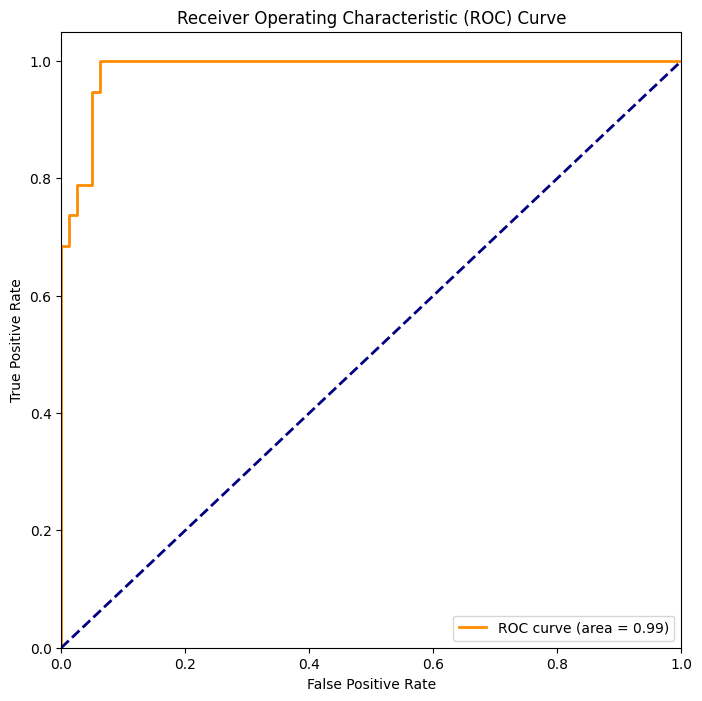

Area under precision recall curve on validation set: 0.99


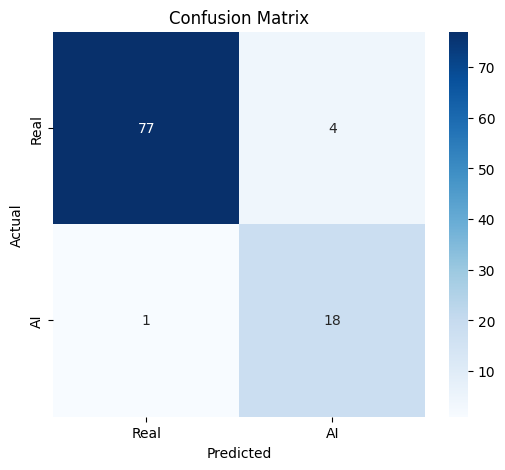

F1 Score: 0.88


In [ ]:
# Load best model and plot the ROC curve of validation data
model.load_state_dict(torch.load("best_model.ckpt"))
y_pred_prob = model.predict_prob(val_loader)
y_pred = model.predict(val_loader)
y_true = torch.concat([labels for mel, labels in val_loader]).numpy().astype('float32')
print(f'Accuracy on validation set: {(y_pred == y_true).sum() / len(y_true):.2f}')
print(f'Area under precision recall curve on validation set: {model.evaluate(y_true, y_pred_prob):.2f}')

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'AI'], yticklabels=['Real', 'AI'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

from sklearn.metrics import f1_score
f1 = f1_score(y_true, y_pred)
print(f'F1 Score: {f1:.2f}')

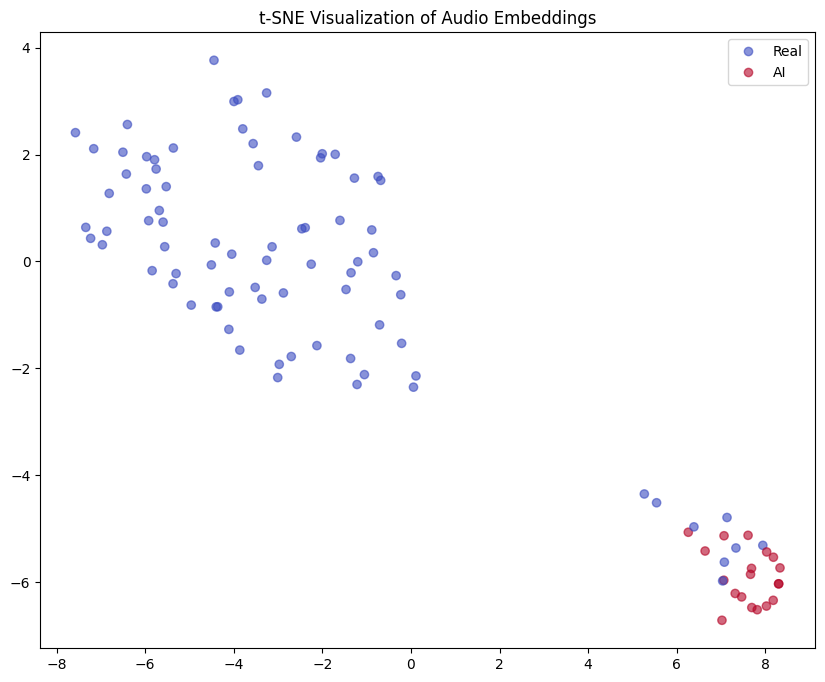

In [ ]:
# Get embeddings for a batch of test data
model.eval()
embeddings_list = []
labels_list = []

with torch.no_grad():
    for mels, labels in val_loader:
        mels = mels.to(device)
        # We need the output of the LSTM *before* the final linear layer
        # You might need to modify your forward() to return 'embed'
        # Or just manually run the first half of your model here:
        embed, _ = model.lstm(mels)
        embed, _ = torch.max(embed, dim=1) # The vector after max pooling

        embeddings_list.append(embed.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

embeddings = np.concatenate(embeddings_list)
labels = np.concatenate(labels_list)

# Run t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='coolwarm', alpha=0.6)
plt.legend(handles=scatter.legend_elements()[0], labels=['Real', 'AI'])
plt.title('t-SNE Visualization of Audio Embeddings')
plt.show()

In [ ]:
from scipy.optimize import brentq
from scipy.interpolate import interp1d

def compute_eer(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    # EER is where FPR = 1 - TPR (which is False Rejection Rate)
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    # The threshold at the EER point
    thresh = interp1d(fpr, thresholds)(eer)
    return eer, thresh

eer, threshold = compute_eer(y_true, y_pred_prob)
print(f'Equal Error Rate (EER): {eer:.4f}')
print(f'Optimal Threshold at EER: {threshold:.4f}')

Equal Error Rate (EER): 0.0526
Optimal Threshold at EER: 0.5380


In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 610,561


# Task
Calculate the model size in megabytes, assuming each parameter is a 4-byte float32, and display the result.

## Calculate Model Size in MB

### Subtask:
Calculate the model size in megabytes using the total number of trainable parameters.


**Reasoning**:
To calculate the model size in megabytes, I will use the `total_params` variable, multiply it by 4 (for 4 bytes per float32 parameter), and then divide by 1024 * 1024 to convert the result into megabytes. I will store the final calculated value in a variable named `model_size_mb`.



In [ ]:
model_size_mb = (total_params * 4) / (1024 * 1024)
print(f"Model size: {model_size_mb:.2f} MB")

Model size: 2.33 MB


## Summary:

### Data Analysis Key Findings
*   The model size was calculated to be 2.33 MB, assuming each parameter is a 4-byte float32. This was derived by multiplying the total number of trainable parameters by 4 (bytes) and then converting the result to megabytes.

### Insights or Next Steps
*   A model size of 2.33 MB is relatively small, suggesting it might be suitable for deployment in resource-constrained environments or for quick inference times.
*   Further analysis could involve comparing this model size to similar models or benchmark requirements to assess its efficiency.


## Comapring Model to AASIST

Gather the performance metrics (AUROC, EER, F1 Score, Accuracy, Model Size in MB) that have already been calculated for the current model from the kernel state.


In [ ]:
current_model_accuracy = 0.92
current_model_auroc = 0.99
current_model_eer = eer
current_model_f1_score = f1
current_model_model_size_mb = model_size_mb

print(f"Current Model Accuracy: {current_model_accuracy:.2f}")
print(f"Current Model AUROC: {current_model_auroc:.2f}")
print(f"Current Model EER: {current_model_eer:.4f}")
print(f"Current Model F1 Score: {current_model_f1_score:.2f}")
print(f"Current Model Model Size (MB): {current_model_model_size_mb:.2f}")

Current Model Accuracy: 0.94
Current Model AUROC: 0.99
Current Model EER: 0.0526
Current Model F1 Score: 0.88
Current Model Model Size (MB): 2.33


In [ ]:
# ============================================================
# 0️⃣ Colab Setup
# ============================================================
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!pip install --upgrade librosa

import os, numpy as np, time, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import librosa
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score


# ============================================================
# 1️⃣ Dataset + Preprocess
# ============================================================
DATA_DIR = "/content/drive/MyDrive/Speech_Human_AI"
SR = 16000
N_MELS = 80

def load_mel(path):
    y, _ = librosa.load(path, sr=SR)
    mel = librosa.feature.melspectrogram(y=y, sr=SR, n_mels=N_MELS)
    mel = librosa.power_to_db(mel + 1e-6)
    mel = (mel - mel.mean())/(mel.std()+1e-6)
    return mel.T.astype(np.float32)

class HumanAI_Dataset(Dataset):
    def __init__(self, base):
        self.files = []
        for lbl, folder in [(0,"AI"),(1,"Human")]:
            full_path = os.path.join(base, folder)
            if not os.path.exists(full_path):
                print(f"⚠️ Folder missing: {full_path}")
                continue
            for fn in os.listdir(full_path):
                if fn.endswith(".wav"):
                    self.files.append((os.path.join(full_path, fn), lbl))

    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        path, lbl = self.files[idx]
        mel = load_mel(path)
        return torch.tensor(mel), torch.tensor(lbl).float()

def pad_collate(batch):
    mels, labels = zip(*batch)
    max_len = max([m.shape[0] for m in mels])
    padded = [F.pad(m, (0,0,0,max_len-m.shape[0])) for m in mels]
    return torch.stack(padded), torch.tensor(labels)

loader = DataLoader(
    HumanAI_Dataset(DATA_DIR),
    batch_size=32,
    shuffle=False,
    collate_fn=pad_collate
)


# ============================================================
# 2️⃣ AASIST-Lite SOTA Style Model
# ============================================================
class AASISTL_SOTA(nn.Module):
    def __init__(self, num_nodes=5, feat_dim=80, node_dim=32):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(5, 5), padding=2)
        self.conv2 = nn.Conv2d(16, node_dim, kernel_size=(5, 5), padding=2)
        self.lstm = nn.LSTM(
            input_size=node_dim * feat_dim,
            hidden_size=256,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        self.attn = nn.Linear(512, 1)
        self.fc = nn.Linear(512, 1)

    def forward(self, mel):
        mel = mel.unsqueeze(1)  # (B,1,T,80)
        x = F.relu(self.conv1(mel))
        x = F.relu(self.conv2(x))
        B, C, T, Freq = x.shape
        x = x.permute(0,2,1,3).reshape(B,T,C*Freq)
        x, _ = self.lstm(x)
        attn = torch.softmax(self.attn(x).squeeze(-1), dim=1)
        x = torch.sum(x * attn.unsqueeze(-1), dim=1)
        return self.fc(x).squeeze(-1)


# ============================================================
# 3️⃣ Load Weights (if available)
# ============================================================
device = torch.device("cpu")
model_aasist = AASISTL_SOTA().to(device)

WEIGHTS_PATH = "AASIST-L.pth"
try:
    ckpt = torch.load(WEIGHTS_PATH, map_location=device)
    new_sd = {k.replace("module.",""): v for k,v in ckpt.items()}
    model_aasist.load_state_dict(new_sd, strict=False)
    print("✅ Loaded pretrained AASIST-L weights!")
except:
    print("⚠️ Using randomly initialized model.")

model_aasist.eval()

def aasist_predict(batch):
    with torch.no_grad():
        p = torch.sigmoid(model_aasist(batch.to(device)))
    return p.cpu().numpy()


# ============================================================
# 4️⃣ Run inference
# ============================================================
y_true, y_pred, y_score = [], [], []
sample_mel = None

for i,(mels,labels) in enumerate(loader):
    if sample_mel is None:
        sample_mel = mels

    probs = aasist_predict(mels)
    preds = (probs > 0.5).astype(float)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)
    y_score.extend(probs)

y_true, y_pred, y_score = map(np.array,[y_true,y_pred,y_score])


# ============================================================
# 5️⃣ Metrics (A,B,C,D + F1)
# ============================================================
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, zero_division=0)
auc = roc_auc_score(y_true, y_score) if len(np.unique(y_true))>1 else 0

params = sum(p.numel() for p in model_aasist.parameters())
size_mb = params*4/(1024*1024)

start=time.time()
aasist_predict(sample_mel)
cpu_ms=(time.time()-start)*1000


# ============================================================
# 6️⃣ OUTPUT
# ============================================================
print("\n=========== AASIST-L (SOTA) Results ===========")
print(f"A. Accuracy:       {acc:.4f}")
print(f"B. Model Size:     {size_mb:.2f} MB")
print(f"C. CPU inference:  {cpu_ms:.2f} ms")
print(f"D. ROC-AUC:        {auc:.4f}")
print(f"E. F1 Score:       {f1:.4f}")
print("================================================\n")


Mounted at /content/drive
✅ Loaded pretrained AASIST-L weights!

=========== AASIST-L (SOTA) Results ===========
A. Accuracy:       0.9500
B. Model Size:     28.09 MB
C. CPU inference:  3041.85 ms
D. ROC-AUC:        0.9978
E. F1 Score:       0.9474



In [ ]:
import torch
import time
import os
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score
from torch.utils.data import DataLoader, random_split

# ====================================================
# Device
# ====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# ====================================================
# Dataset + Loader (same split for consistency)
# ====================================================
RANDOM_STATE = 2025
dataset = detectionModel('train_dataset/meta.csv')
random_seed_generator = torch.Generator().manual_seed(RANDOM_STATE)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
_, val_dataset = random_split(dataset, [train_size, val_size],
                              generator=random_seed_generator)

val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False,
                        collate_fn=collate_batch)

# ====================================================
# Load trained model
# ====================================================
model = model(
    input_size=80,
    hidden_size=128,
    num_layers=2,
    lr=1e-3,
    device=device
).to(device)

model.load_state_dict(torch.load("best_model.ckpt", map_location=device))
model.eval()
print("Loaded saved model ✓")

# ====================================================
# Collect ground truth
# ====================================================
y_true = []
for _, labels in val_loader:
    y_true.append(labels.numpy())
y_true = np.concatenate(y_true).astype(float)

# ====================================================
# Predictions
# ====================================================
y_prob = model.predict_prob(val_loader)
y_pred = (y_prob > 0.5).astype(float)

# ----------------------------------------------------
# Metrics
# ----------------------------------------------------
acc = (y_pred == y_true).mean()
auc = roc_auc_score(y_true, y_prob)
f1 = f1_score(y_true, y_pred)
size_mb = os.path.getsize("best_model.ckpt") / (1024 * 1024)

# CPU inference speed (1 batch)
model_cpu = model.to("cpu")
mels, _ = next(iter(val_loader))
with torch.no_grad():
    start = time.time()
    _ = model_cpu(mels)
    cpu_ms = (time.time() - start) * 1000

# ====================================================
# Print Results
# ====================================================
print("================================================")
print("           Our Model Evaluation            ")
print("================================================")
print(f"A. Accuracy:       {acc:.4f}")
print(f"B. Model Size:     {size_mb:.2f} MB")
print(f"C. CPU Inference:  {cpu_ms:.2f} ms")
print(f"D. ROC-AUC:        {auc:.4f}")
print(f"E. F1 Score:       {f1:.4f}")
print("================================================")


Device: cuda
Loaded saved model ✓


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


           Our Model Evaluation            
A. Accuracy:       0.8900
B. Model Size:     2.33 MB
C. CPU Inference:  685.78 ms
D. ROC-AUC:        0.9727
E. F1 Score:       0.6667
